**今回の実習内容**
 * 関数について
 * OpenCVを利用した画像処理
 * 相関係数の計算
 * 実習課題

**モジュールのインポート**

In [1]:
import sys, math, os
import numpy as np
import time
import copy
import tifffile as tiff
from matplotlib import pyplot as plt

# OpenCV, Pillowのインポート
import cv2   # opencvだけどimportの時はcv2
#from PIL import Image   # Pillowだけどimportの時はPIL

**Pythonの基礎：関数について**
 * 関数：y = f(x), xに対してyを返す
 * プログラミングにおける関数：入力に対して出力を返す
   *  入力された配列の平均値を出力する
   *  入力ファイル名を読んで画像を出力する
   *  入力なしで、呼ばれると円周率の値だけを返す
 * 入力(**引数, argument**)は複数あってもいい

In [2]:
# 関数の例
# JupyterLabでは1つのセルに1つの関数を定義するのがおすすめ

# 角度と並進ベクトル(任意)を入力すると同次変換行列を返す関数
def RotationMatrix2D(theta, angunit, tx=0.0, ty=0.0):
    if not ((angunit=='deg') or (angunit=='rad')):
        print("Error: invalid angular unit")
        sys.exit()

    if (angunit=='deg'):
        theta *= np.pi / 180.0

    # 詳細は省くが、ここでは一番下の[0,0,1]の行は考えなくてよい
    r2d = np.zeros((2,3), dtype=float)
    r2d[0,0] = np.cos(theta)
    r2d[0,1] = -1.0 * math.sin(theta)
    r2d[1,0] = np.sin(theta)
    r2d[1,1] = np.cos(theta)
    r2d[0,2] = tx
    r2d[1,2] = ty

    return r2d

In [3]:
# 並進だけする同次変換行列を返す関数
def TranslationMatrix2D(tx=0.0, ty=0.0):
    r2d = np.zeros((2,3), dtype=float)
    r2d[0,0] = 1.0
    r2d[0,1] = 0.0
    r2d[1,0] = 0.0
    r2d[1,1] = 1.0
    r2d[0,2] = tx
    r2d[1,2] = ty

    return r2d

In [4]:
# 関数の使用例

# degree
theta = 30
tx = 1.5
ty = 1.5

rot1 = RotationMatrix2D(theta, 'deg', tx, ty)

print('rotation matrix in theta = 30 deg:')
print(rot1)

rotation matrix in theta = 30 deg:
[[ 0.8660254 -0.5        1.5      ]
 [ 0.5        0.8660254  1.5      ]]


In [5]:
# radian

rot2 = RotationMatrix2D(np.pi/2.0, 'rad')

print('')
print('rotation matrix in theta = pi / 2 rad:')
print(rot2)


rotation matrix in theta = pi / 2 rad:
[[ 6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]]


In [6]:
# invalid angular unit

rot3 = RotationMatrix2D(45, 'aaa') 

Error: invalid angular unit


SystemExit: 

/Users/mao/miniconda3/envs/impr/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
# システムやモジュールの関数を使ってみる
# ndarrayの関数

a = np.array([[1,2],[3,4],[5,6]])   # 3行2列の配列
print('2D array a:')
print(a)

2D array a:
[[1 2]
 [3 4]
 [5 6]]


In [8]:
# 配列の形状を返す関数 shape
print('shape of a: ', a.shape)   # shape自体が配列

print('row size of a: ', a.shape[0])   # 行サイズを出力
print('column size of a: ', a.shape[1])      # 列サイズを出力

shape of a:  (3, 2)
row size of a:  3
column size of a:  2


In [9]:
# 配列の和を返す関数 sum
print('sum of a: ', a.sum())   # 要素全体の和
print('sum over row: ', a.sum(axis=0))   # 行について和をとる
print('sum over col: ', a.sum(axis=1))   # 列について和をとる

sum of a:  21
sum over row:  [ 9 12]
sum over col:  [ 3  7 11]


In [10]:
# 配列の平均を返す関数 mean
print('mean of a: ', a.mean())   # 要素全体の平均
print('mean over row: ', a.mean(axis=0))   # 行について平均をとる
print('mean over col: ', a.mean(axis=1))   # 列について平均をとる

mean of a:  3.5
mean over row:  [3. 4.]
mean over col:  [1.5 3.5 5.5]


**その他についても nkmk note で確認可能**

**OpenCVを使って画像を回転させてみる**
 * 画像を読み込む
 * 回転角を決めて、同次変換行列を計算する
 * 同次変換行列を使って画像を回転させる
 * 回転後の画像を表示

(440, 440)


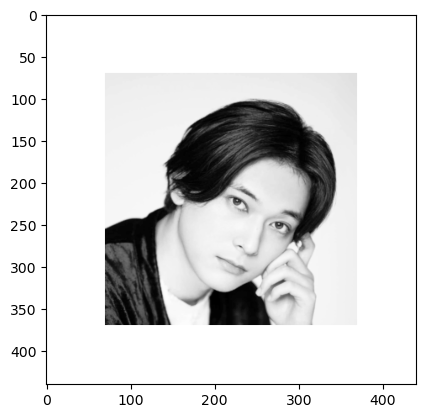

In [11]:
# 画像の読み込み

fn_in = './data/test_yoshizawa.tif'
image = tiff.imread(fn_in)
print(image.shape)

ysize = image.shape[0]   # 行のサイズなのでy
xsize = image.shape[1]   # 列のサイズなのでx

plt.imshow(image, cmap='Greys')

In [12]:
# 回転行列の計算

theta = 45 # 度回す

rot = RotationMatrix2D(-1.0*theta, 'deg', -91.127, 220)   # なぜtheta, tx, tyの値がこうなるかは後で説明
print(rot)

[[  0.70710678   0.70710678 -91.127     ]
 [ -0.70710678   0.70710678 220.        ]]


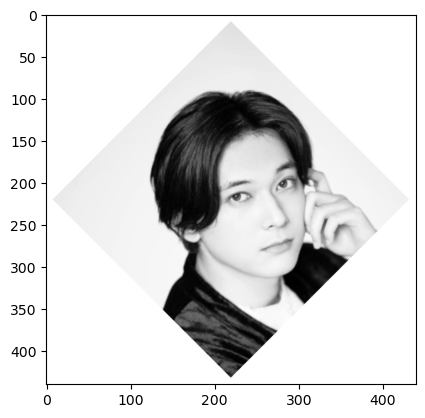

In [13]:
# 回転画像の計算

# 使い方は 回転画像 = cv2.warpAffine(元画像, 同次変換行列, (xsize, ysize), 補間方法)
# 下ではBilinearを指定
rotimage = cv2.warpAffine(image, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)

# 回転後の画像を表示
plt.imshow(rotimage, cmap='Greys')

**先ほどの妙な同次変換行列について**
 * 実はcv2.warpAffineは定義通りの変換行列を入力するとうまくいかない
 * うまくいく行列はcv2.getRotationMatrix2Dで計算可能
 * getRotationMatrix2D((xcenter, ycenter), theta, scale(縮尺なので1.0でOK))

In [14]:
# opencvでの変換行列の計算

rot_cv2 = cv2.getRotationMatrix2D((xsize / 2., ysize / 2.), theta, 1.0)

print(rot_cv2)

[[  0.70710678   0.70710678 -91.12698372]
 [ -0.70710678   0.70710678 220.        ]]


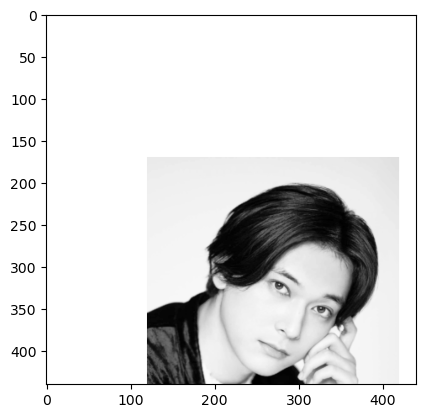

In [15]:
# 並進だけをする場合

trans = TranslationMatrix2D(50,100)

transimage = cv2.warpAffine(image, trans, (xsize, ysize), flags=cv2.INTER_LINEAR)

plt.imshow(transimage, cmap='Greys')

**別のライブラリ、Pillowによる回転**
 * Pillowを使う場合、変換行列の計算を挟まず回転角と中心を指定すればそのまま変換できる
 * ただし、Pillowを使うなら最初からPillowを使って開かなければいけない

In [ ]:
# Pillowによる画像の回転

# 画像の読み込み
pilimage = Image.open(fn_in)

# 画像のサイズを表示 (array.shapeと同じ操作)
print(pilimage.size)

# 画像の回転
rot_pilimage = pilimage.rotate(45, resample=Image.BILINEAR)

a = np.asarray(rot_pilimage)
plt.imshow(a, cmap='Greys')

# 回転画像の書き出し
#fn_out = './course02/test_yoshizawa_pilrot.tif'
#rot_pilimage.save(fn_out)

# 保存した画像の読み込み、表示
#saved_image = tiff.imread(fn_out)
#plt.imshow(saved_image, cmap='Greys')

**相関係数の計算**

In [16]:
# 関数を定義しておく

def calc_cc(x,y):

    x -= x.mean()
    y -= y.mean()

    frac = 0.
    denom_x = 0.
    denom_y = 0.
    for k in range(x.size):
        frac += x[k] * y[k]
        denom_x += x[k] * x[k]
        denom_y += y[k] * y[k]

    return frac / math.sqrt(denom_x * denom_y)


**座学資料と同様のcc計算を座標を選んでやってみる**

(50, 50)


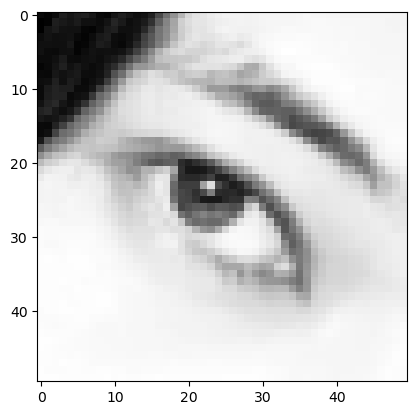

In [17]:
# テンプレート画像の読み込み

fn_temp = './data/test_yoshizawa_cc_template.tif'
template = tiff.imread(fn_temp)
print(template.shape)

ytemp = template.shape[0]   # 行のサイズなのでy
xtemp = template.shape[1]   # 列のサイズなのでx

template1d = template.flatten()

plt.imshow(template, cmap='Greys')

xrange:  132  <= x <=  182 ,  50
yrange:  127  <= y <=  177 ,  50
0.58514816


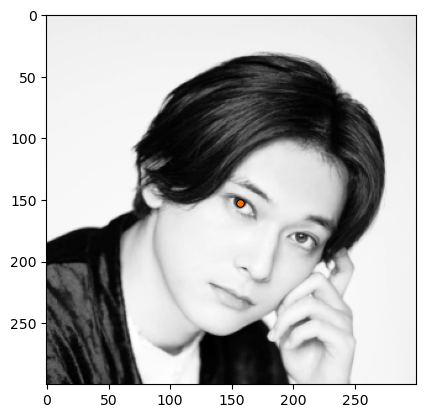

In [19]:
# ccを計算する領域の中心座標を指定
xcenter = 157   # 0 <= xcenter <= 224
ycenter = 152   # 0 <= ycenter <= 224

# 元画像の読み込み
fn_in = './data/test_yoshizawa_cc.tif'
image = tiff.imread(fn_in)

ysize = image.shape[0]   # 行のサイズなのでy
xsize = image.shape[1]   # 列のサイズなのでx

# ccを計算するエリアの設定
xmin = int(xcenter - (xtemp / 2))
xmax = int(xcenter + (xtemp / 2))
xrange = int(xmax - xmin)

ymin = int(ycenter - (ytemp / 2))
ymax = int(ycenter + (ytemp / 2))
yrange = int(ymax - ymin)

print('xrange: ', xmin, ' <= x <= ', xmax, ', ', xrange)
print('yrange: ', ymin, ' <= y <= ', ymax, ', ', yrange)

# xcenter, ycenterを元にテンプレートと比較する領域を切り出し
ccarea = image[xmin:xmax, ymin:ymax].flatten()

# ccを計算
cc = calc_cc(template1d, ccarea)
print(cc)

# ccの値を中心座標でプロット
plt.imshow(image, cmap='Greys')
cmap = plt.get_cmap('jet')
plt.scatter(xcenter, ycenter, c=cc, vmin=-1.0, vmax=1.0, s=30, cmap=cmap, lw=0.75, edgecolors='k')

**実習課題**
 * 以下の画像のテンプレートピックをしてみましょう
 * ただし、回転なし、並進だけでできるようになっています
 * for文で画像領域を繰り返し変えてccを計算してみましょう
 * 正しい位置の近傍もccが高くなってしまいますが、正しい位置では1.0(0.9999999...)になるはず
 * 上の条件を使えば正しい位置だけピックできます
 * 実際に粒子像を切り出して確認してみるとさらによいです

**テンプレート**

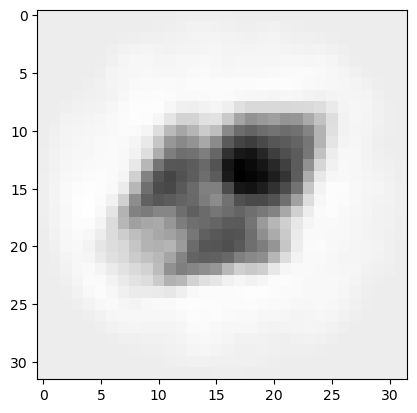

In [20]:
fn_temp = './data/course2_bgal_temp.tif'
template = tiff.imread(fn_temp)

plt.imshow(template, cmap='Greys')

**テスト画像**

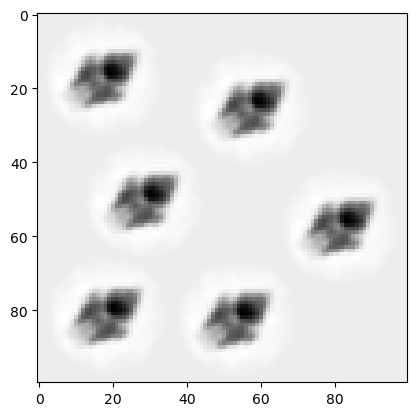

In [21]:
fn_mic = './data/course2_bgal.tif'
micrograph = tiff.imread(fn_mic)

plt.imshow(micrograph, cmap='Greys')

**発展課題**
 * 回転込みのテンプレートピックをしてみましょう
 * 回転は10度単位です
 * そのままやると横ピクセル数x縦ピクセル数x回転のステップ数になって大変です
 * まず並進だけで相関が高そうなところを集めて、そこだけで回転込みのcc計算をするとラクできると思います
 * ただし、実際のテンプレートピックでそういうことをしているわけではないです

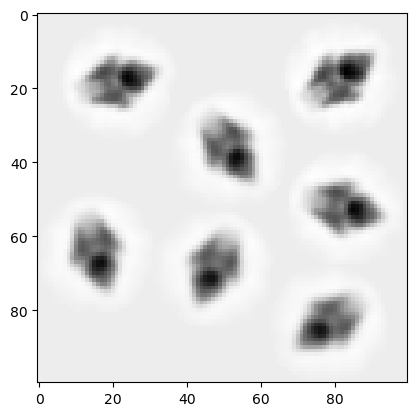

In [22]:
fn_mic_rot = './data/course2_bgal_rot.tif'
micrograph_rot = tiff.imread(fn_mic_rot)

plt.imshow(micrograph_rot, cmap='Greys')